In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS 
from tools.ae_v3 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-16 17:10:57.659784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:10:57.660303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:10:57.740724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:10:57.741106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 17:10:57.741409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_016'.format(ds=dir_sep)

with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_016
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

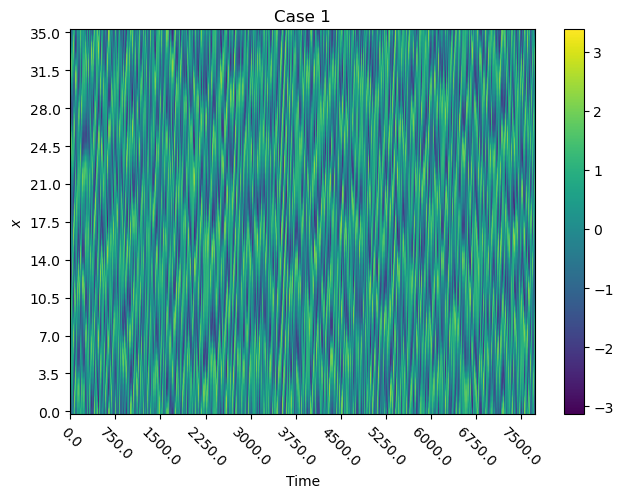

In [15]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = 25*np.round(10*float(sn[0:-6])/25)/10
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if normalizeforae_flag == True:
    for i in range(numpoints_xgrid):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

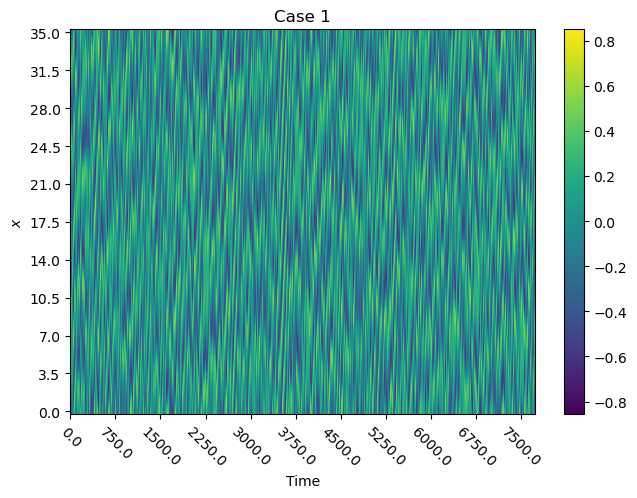

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

# Autoencoder

In [18]:
# setting up training params
with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
    lines = f.readlines()

tparams_dict = eval(''.join(lines))

learning_rate_list = tparams_dict['learning_rate_list']
epochs = tparams_dict['epochs']
patience = tparams_dict['patience']
min_delta = tparams_dict['min_delta']
prng_seed = tparams_dict['prng_seed']
train_split = tparams_dict['train_split']
val_split = tparams_dict['val_split']
batch_size = tparams_dict['batch_size']

test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [19]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [20]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [21]:
# Initialize network
load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)

wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
ae_net.load_weights_from_file(wt_file)

In [22]:
with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
    lines = f.readlines()

losses_dict = eval(''.join(lines))

val_loss_hist = losses_dict['val_loss_hist']
train_loss_hist = losses_dict['train_loss_hist']
lr_change = losses_dict['lr_change']
test_loss = losses_dict['test_loss']

In [23]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

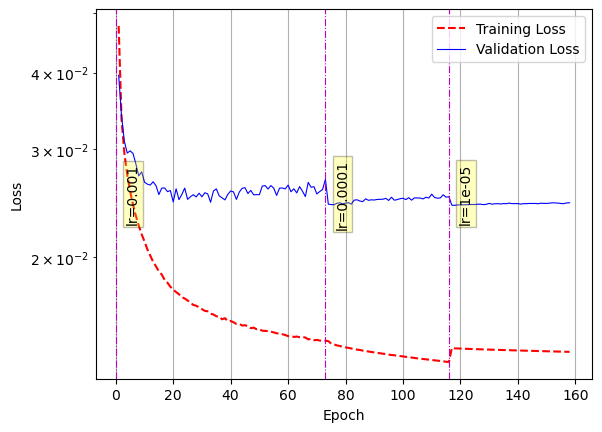

In [24]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [25]:
reconstructed_data = ae_net.predict(all_data)

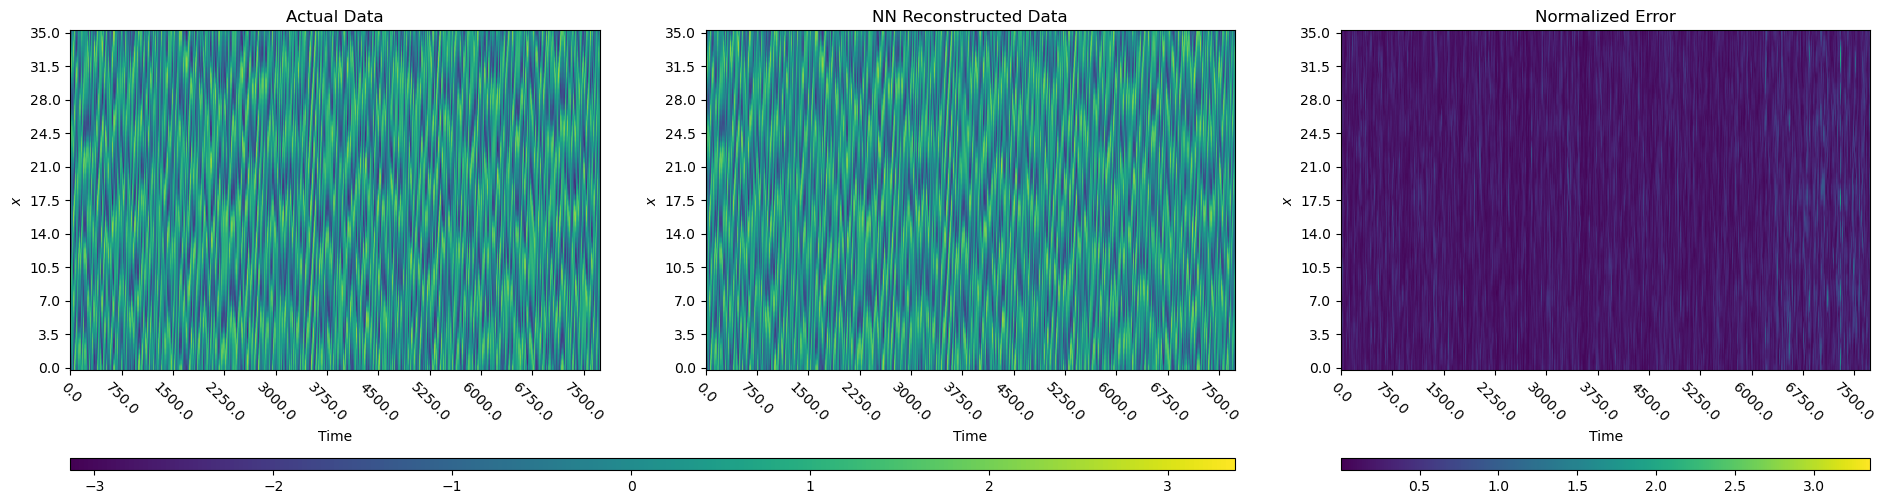

In [26]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [27]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

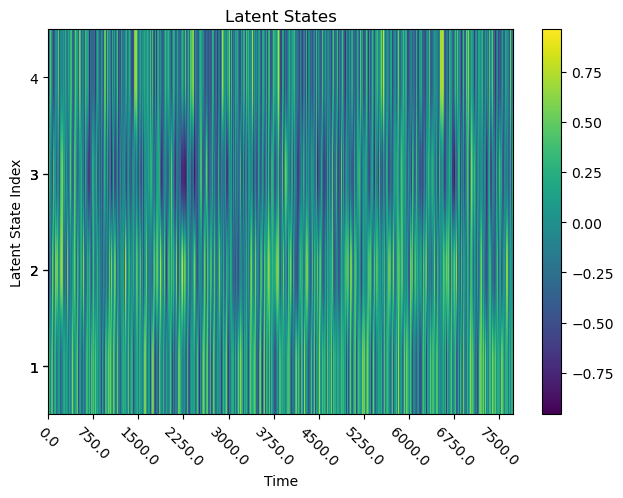

In [28]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=False)

In [29]:
save_dir = dir_name_ae+dir_sep+'plots'

In [30]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []
KE_nrmse = []

if normalizeforae_flag == True:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]].copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]].copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_aedata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_aedata[0, i]
else:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)

    KE_rmse = np.mean((KE_recon - KE_org)**2)**0.5
    KE_mean = np.mean(KE_org)
    KE_rmse_normalized = KE_rmse/KE_mean
    KE_nrmse.append(KE_rmse_normalized)

    begin_idx = boundary_idx_arr[i]

In [31]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    print(lyap_time)
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time

    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$KE$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    # ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )
    
    # plt.colorbar(im)
    if save_dir is not None:
        fig.savefig(save_dir+dir_sep+'KE-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

15.466301


In [32]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [33]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []
D_nrmse = []

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    D_rmse = np.mean((D_recon - D_org)**2)**0.5
    D_mean = np.mean(D_org)
    D_rmse_normalized = D_rmse/D_mean
    D_nrmse.append(D_rmse_normalized)
    
    begin_idx = boundary_idx_arr[i]

In [34]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$D$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    if save_dir is not None:
        fig.savefig(save_dir+'/Dissipation-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

In [35]:
np.savez(
    dir_name_ae+dir_sep+'KE_D_data',
    KE_org_list=KE_org_list,
    KE_reconstructed_list=KE_reconstructed_list,
    KE_nrmse=KE_nrmse,
    D_org_list=D_org_list,
    D_reconstructed_list=D_reconstructed_list,
    D_nrmse=D_nrmse,
    num_latent_states=[latent_states_all.shape[1]],
)